<img src="https://i.ibb.co/6PYWPTQ/V02PE02.png" alt="V02PE02" align="center"/>

# Hello & Introduction #

Howdy, I am still getting the hang of this, so please feel free to suggest improvements or ideas. 

Today, we will be implementing a Convolutional Nueral Network (CNN) from FastAI to acurrately predict patients with Parkinson's Syndrom. The aim of this work is to establish a supplemental yet reliable, computer method of diagnosis. The model aims at underminding a diagnosis bottleneck where experts are needed to interpret these sketches, especially in the early stages of the disease. With the availability of technology exponentially increasing, this model can be deployed and used to supplement the diagnosis of real individuals.

The data was taken directly from Kevin Mader's [Parkinsons Drawing](https://www.kaggle.com/kmader/parkinsons-drawings). Attached is the [medical article](https://www.frontiersin.org/articles/10.3389/fneur.2017.00435/full) documenting how the data was recorded, how the subjects were chosen, and other features they recorded such as pen pressure, speed, etc.


As of today, all of the models using this dataset have reached ~80% accuracy. **This one will _hopefully_ be a bit more accurate.**

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai import * # import the FastAI v3 lib which includes pytorch
from fastai.vision import  * # import all of the computer vision related libs from vision 

# lets import our necessary magic libs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Constants ####

In [2]:
BATCH_SIZE = 64 
IMG_SIZE = 224
WORKERS = 0 
DATA_PATH_STR = '../input/parkinsons-drawings/'
DATA_PATH_OBJ = Path(DATA_PATH_STR)

#### Creating our Data Block ####
Lets create a DataBunch object to feed our model with the appropriate training and testing data for our spiral and waves.

In [3]:
tfms = get_transforms() # standard data augmentation ()

data = (ImageList.from_folder(DATA_PATH_OBJ)        # get data from path object
        .split_by_rand_pct()                        # separate 20% of data for validation set
        .label_from_folder()                          # label based on directory
        .transform(tfms, size=IMG_SIZE)                   # added image data augmentation
        .databunch(bs=BATCH_SIZE, num_workers=WORKERS)    # create ImageDataBunch
        .normalize(imagenet_stats))                   # normalize RGB vals using imagenet stats

In [4]:
# lets check to see if the seperations were done correctls
('training DS size:', len(data.train_ds), 'validation DS size:' ,len(data.valid_ds))

('training DS size:', 327, 'validation DS size:', 81)

In [5]:
# lets check our labels/classes
data.classes

['healthy', 'parkinson']

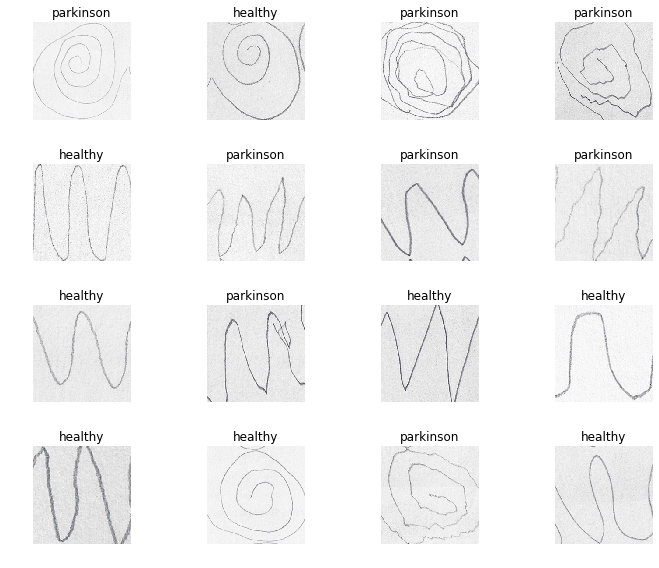

In [6]:
data.show_batch(rows=4, figsize=(10,8))

### Resnet34 Model Creation & Training ###
We will first implement a Convolutional Nueral Network (CNN) with a fully connected head and a single hidden layer as a classifier. I still don't have too much of a clue what that means but i'm rollin' with it. 

In [7]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy, model_dir='/tmp/models')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 24.5MB/s]


In [8]:
# lets start training via one cycle 
learn.fit_one_cycle(7)
# should happen quickly since the dataset is relatively small

epoch,train_loss,valid_loss,accuracy,time
0,1.263906,0.661264,0.629630,00:07
1,1.034919,0.600805,0.790123,00:06
2,0.828379,0.723879,0.765432,00:05
3,0.696805,0.590881,0.827160,00:05
4,0.639209,0.554072,0.827160,00:05
5,0.596292,0.518375,0.864198,00:05
6,0.563822,0.499894,0.864198,00:05


Looks like our model without any finetuning is already realitively accurate with an accuracy of ~86%. 

## Results ##
Lets try to interpret some of these results from the first stage of training by creating a Classification Interpretation object. 

In [9]:
interp = ClassificationInterpretation.from_learner(learn)

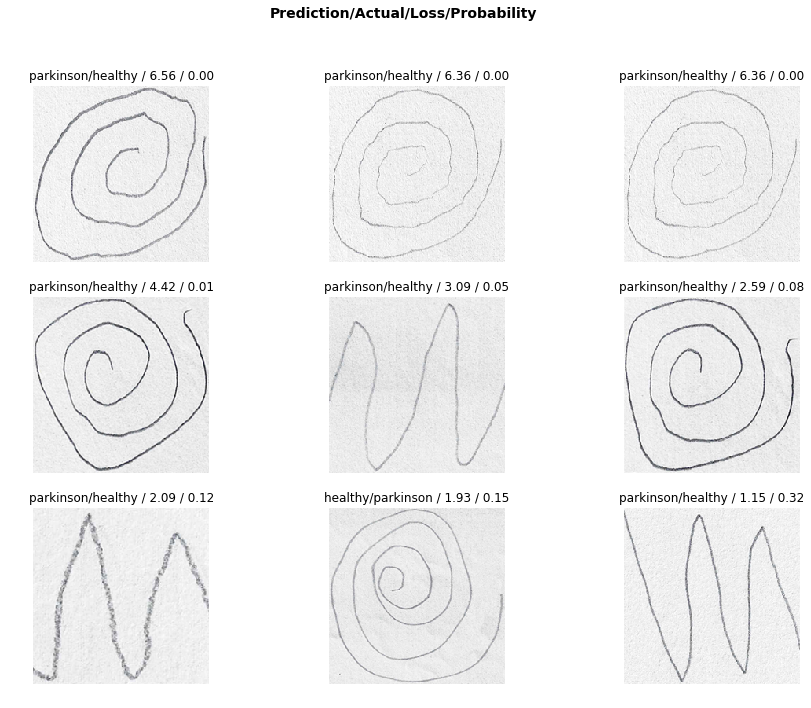

In [10]:
# show me what the model was most confident in yet, was incorrect.
losses,idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))

Keep in mind the figure above shows the **MOST TOP LOSSES** meaning not only the incorrect labelings but also **classes that the model was correct but was highly inconfident/unsure that it was correct, leading to a high loss.**

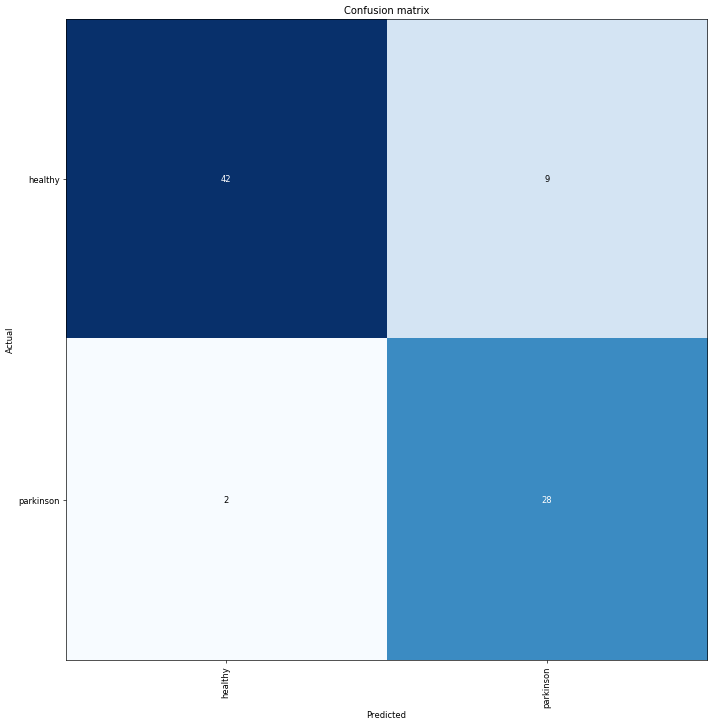

In [11]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [12]:
# lets unfreeze the remainder of the model to see if our model can do better 
learn.unfreeze()

In [13]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.504607,0.700317,0.839506,00:06
1,0.621261,0.512376,0.864198,00:06
2,0.526242,0.341808,0.925926,00:05


Looks like when we unfroze the remaining layers and retrained the entire model, **the loss decreased (the model got more confident) and the accuracy jumped from 86% -> 93% accuracy. **

But can we further optimize the model by calculating the ideal learning rate? 🤔

In [16]:
learn.save('stage-1-92')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 7.59E-06


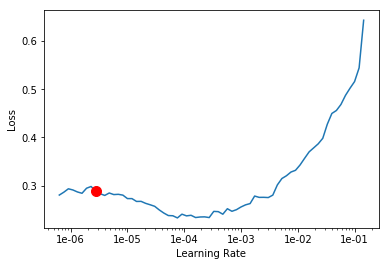

In [17]:
# lets try to find the learning rate to improve the model accuracy
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [19]:
# instead of the default max_lr
# lets pass our cycle the lowest learning rates suggested
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.107268,0.376292,0.913580,00:05
1,0.133411,0.323835,0.962963,00:05


In [20]:
learn.save('stage-2-96')

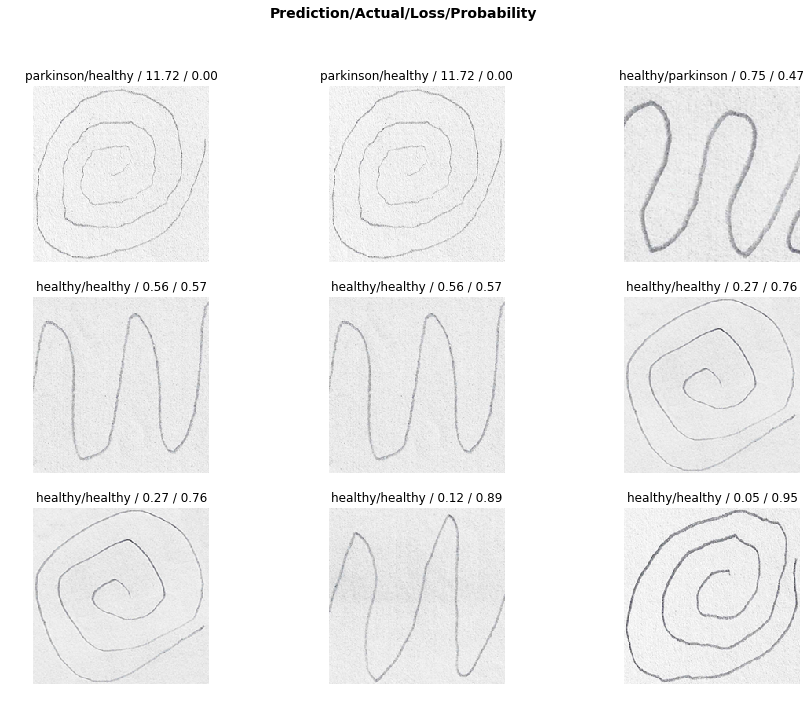

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))

In [22]:
interp.most_confused()

[('healthy', 'parkinson', 2), ('parkinson', 'healthy', 1)]

## Training Resnet50 ##
Seems like our current model is quite accurate already but can we improve it by increasing the number of layers and overall size. We will now scale our resnet34 model into a full blown resnet50.

This model is obviously larger with more layers and thus more expensive in terms of computing.

In [26]:
learn5 = cnn_learner(data, models.resnet50, metrics=accuracy, model_dir='/tmp/models')

In [27]:
# lets fit only our top layers to see how well she does 
learn5.fit_one_cycle(7)

epoch,train_loss,valid_loss,accuracy,time
0,1.057321,0.811916,0.679012,00:06
1,0.965124,0.895019,0.740741,00:06
2,0.819065,0.435555,0.888889,00:06
3,0.715193,0.373045,0.901235,00:06
4,0.631190,0.376846,0.913580,00:06
5,0.574579,0.288603,0.913580,00:06
6,0.530164,0.254769,0.925926,00:06


In [28]:
# lets now unfreeze the rest to see if we can improve
learn5.unfreeze()
learn5.fit_one_cycle(7)

epoch,train_loss,valid_loss,accuracy,time
0,0.427403,0.506024,0.851852,00:06
1,0.438225,0.347442,0.938272,00:06
2,0.395008,0.809328,0.888889,00:06
3,0.391362,0.718007,0.839506,00:06
4,0.348114,0.449954,0.901235,00:06
5,0.345762,0.589675,0.925926,00:06
6,0.321129,0.562463,0.950617,00:06


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05
Min loss divided by 10: 1.20E-04


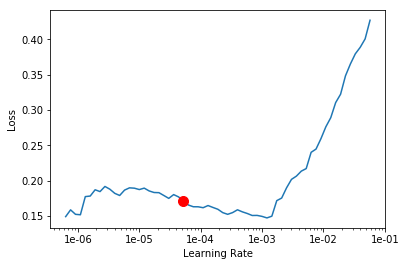

In [32]:
# Lets optimize
learn5.lr_find()
learn5.recorder.plot(suggestion=True)

In [34]:
# now lets fitting with a suggested lr instead of default
learn5.fit_one_cycle(3, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.196159,0.443346,0.975309,00:06
1,0.137298,0.349685,0.975309,00:06
2,0.122579,0.344162,0.975309,00:06


In [36]:
interp50 = ClassificationInterpretation.from_learner(learn5)

In [37]:
interp50.most_confused()

[('healthy', 'parkinson', 2)]

In [38]:
learn50.save('stage-1-97')

# Conclusion & Closing Remarks #

All in all, our resnet 34 model was able to reach close to **96% accuracy while our larger, more expensive resnet50 model was able to reach 98% accuracy**. In the production enviornment, I would opt for our smaller resnet 34 model as it was able to get consistent diagnosis with a lot less overhead and cost. 

It is a bit astonishing to me how accurate these models can be right out of box. The models both surpassed the 85% benchmark with very little finetuning and adjustments needed. But I am a bit skeptical at the ease, are we overfitting? 🤔

In the future, it would be nice to add features such as speed and pen pressure (CISP) or at least try to determine them from the thickness and intensities of the lines on the drawings.

Again, please feel free to reply with feedback and constructive criticism. 

